In [5]:
import pandas as pd

file = "/teamspace/studios/this_studio/deap-dataset/metadata_xls/participant_ratings.xls"
df = pd.read_excel(file)

df

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...,...,...,...,...
1275,32,36,1,30916115,8.13,4.83,9.00,4.87,2.0
1276,32,37,18,31703107,8.03,7.06,8.96,8.18,5.0
1277,32,38,3,32482079,8.05,7.09,8.86,7.08,5.0
1278,32,39,25,33248922,4.01,7.17,8.01,6.94,2.0


In [2]:
import numpy as np
import pickle
import glob
import os

folder = '/teamspace/studios/this_studio/deap-dataset/data_preprocessed_python'

files = sorted(glob.glob(os.path.join(folder, 's*.dat')))

# Use lists first
all_data = []
all_labels = []

# Load and extract 'data' and 'labels' from each file
for file in files:
    with open(file, 'rb') as f:
        subject = pickle.load(f)
        all_data.append(subject['data'])     # shape: (40, 40, 8064)
        all_labels.append(subject['labels']) # shape: (40, 4)

# Convert to NumPy arrays                       32 x 40 = 1280
all_data = np.concatenate(all_data, axis=0)     # shape: (1280, 40, 8064)
all_labels = np.concatenate(all_labels, axis=0) # shape: (1280, 4)

# 32 personas vieron 40 videos cada una, de cada video se extrajo señales en 8064 instantes por cada uno de los 40 canales (tipos de señales)
# nosotros vamos a usar solo los primeros 32 canales de las señales como lo hace el autor del paper (solo señales EEG)

In [3]:
print(type(all_data))
print(all_data.shape)
print(type(all_labels))
print(all_labels.shape)
print(all_labels)

<class 'numpy.ndarray'>
(1280, 40, 8064)
<class 'numpy.ndarray'>
(1280, 4)
[[1.29 1.4  6.9  7.83]
 [0.9  1.69 7.28 8.47]
 [0.42 1.46 9.   7.08]
 ...
 [3.05 7.01 5.1  1.1 ]
 [3.99 7.17 4.85 1.  ]
 [7.15 4.03 9.   1.88]]


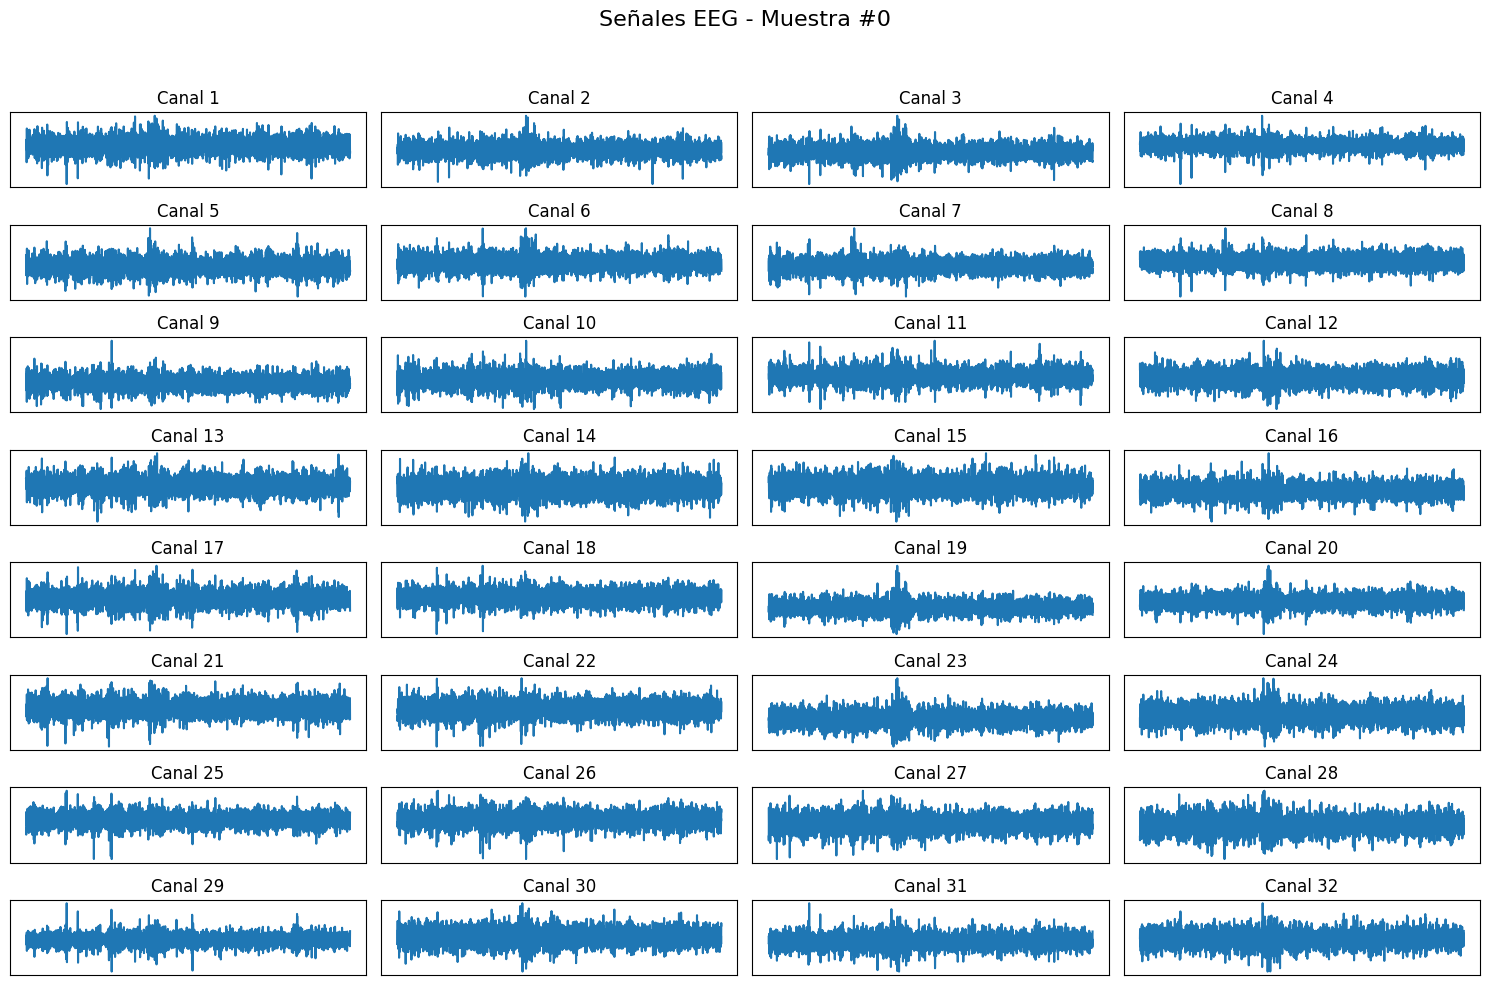

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Seleccionar una muestra (entre 0 y 1279)
sample_idx = 0  # Cambia esto para ver otra muestra

# Seleccionar solo los 32 primeros canales (EEG)
eeg_data = all_data[sample_idx, :32, :]  # shape: (32, 8064)

# Graficar las 32 señales EEG
fig, axs = plt.subplots(8, 4, figsize=(15, 10))
fig.suptitle(f'Señales EEG - Muestra #{sample_idx}', fontsize=16)

for i in range(32):
    row = i // 4
    col = i % 4
    axs[row, col].plot(eeg_data[i])
    axs[row, col].set_title(f'Canal {i+1}')
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


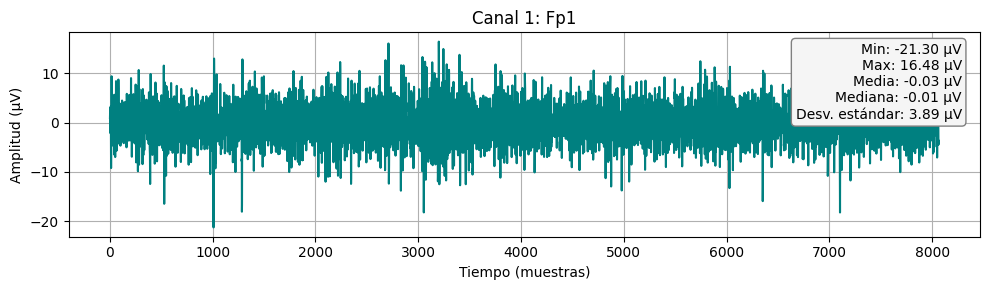

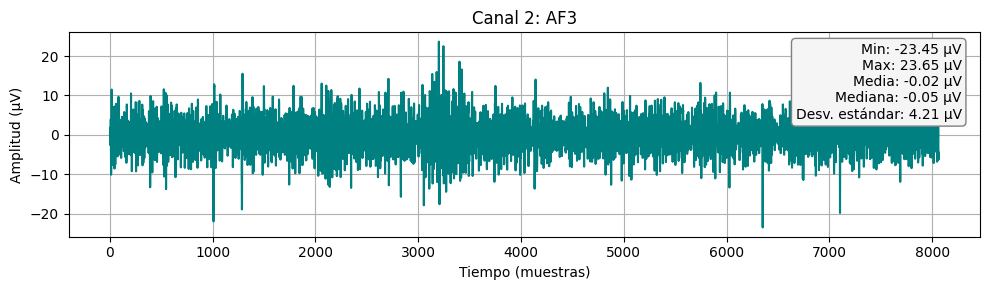

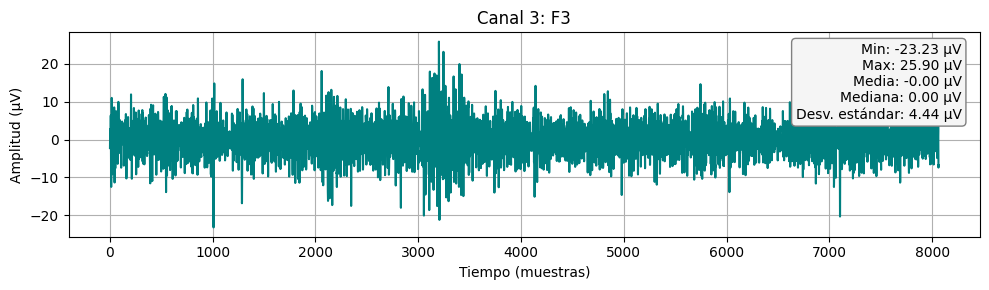

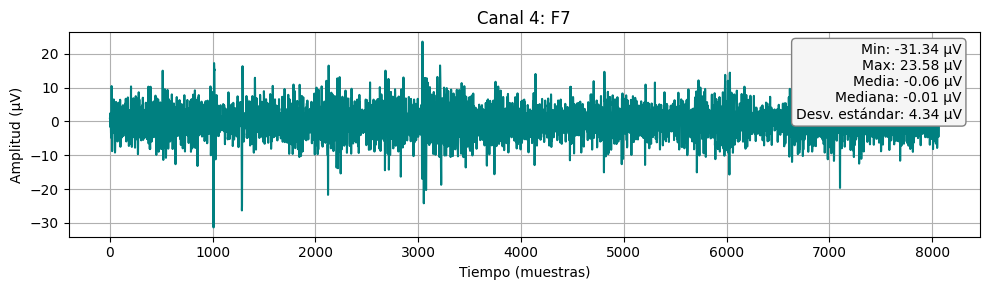

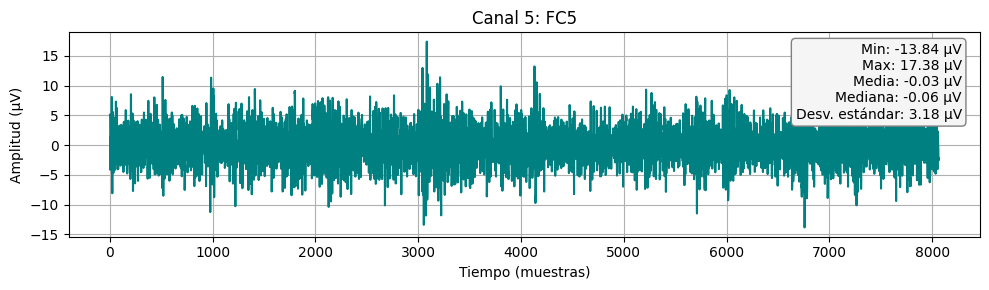

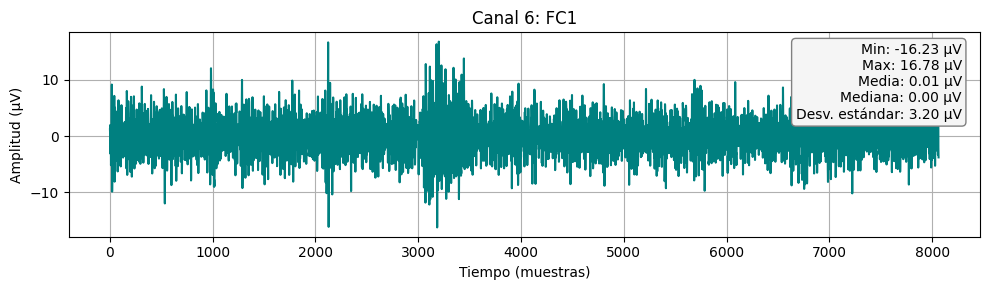

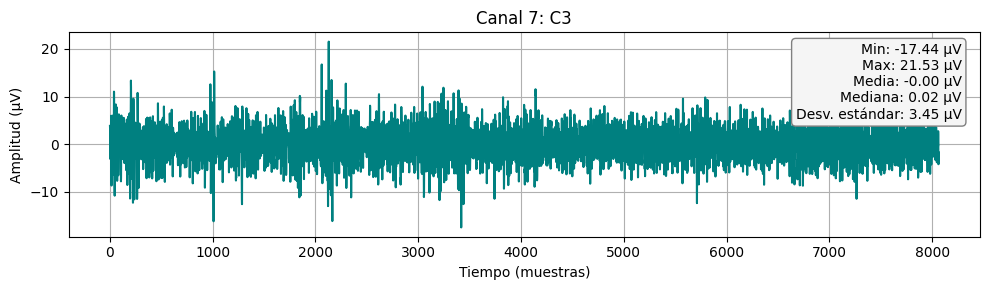

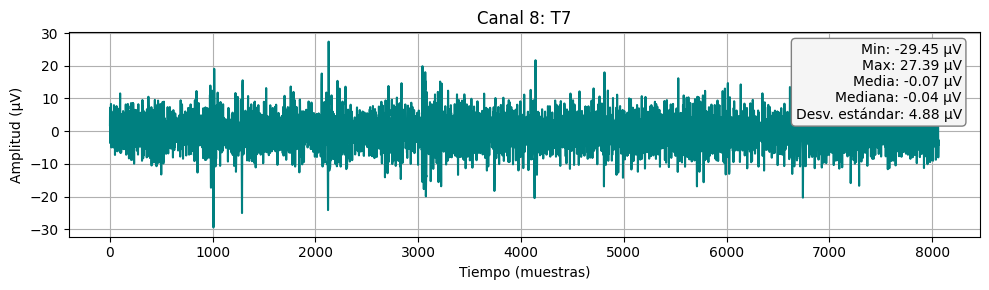

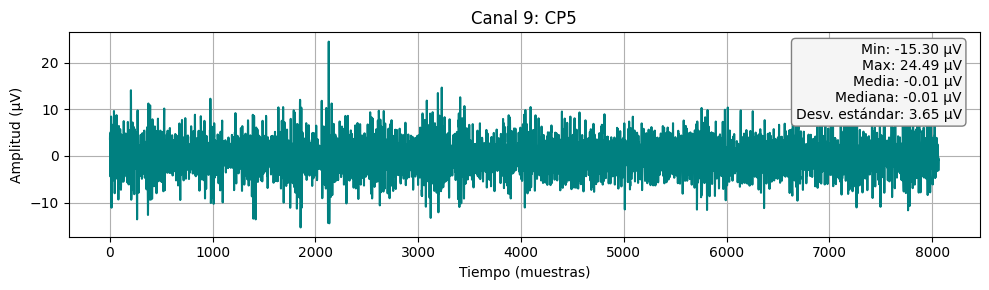

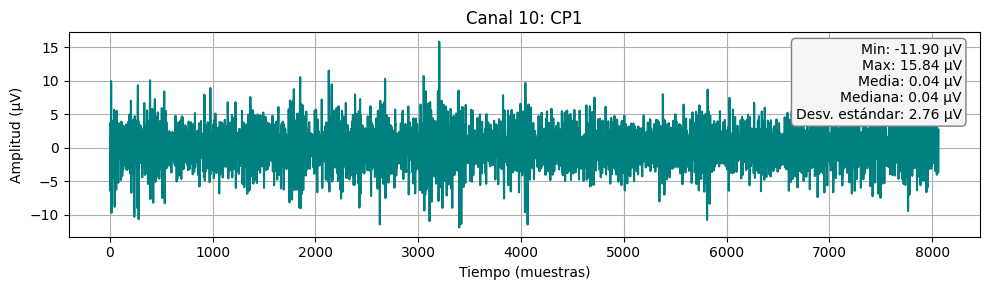

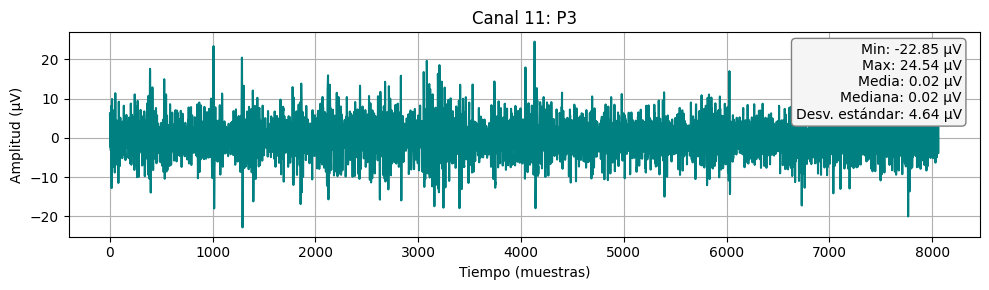

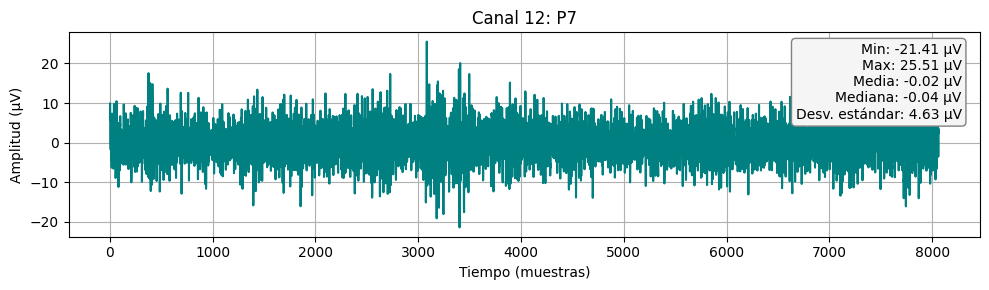

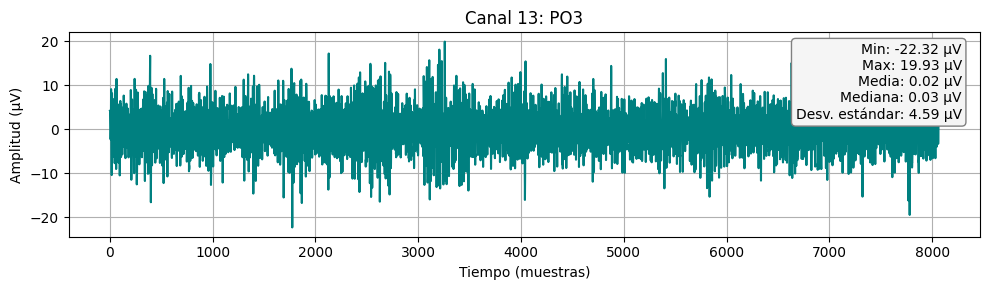

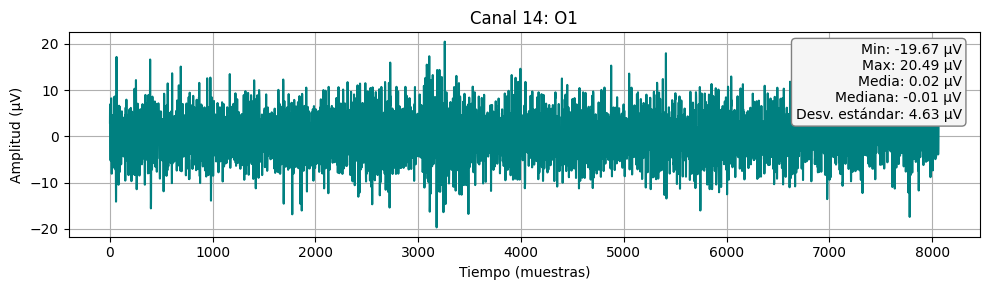

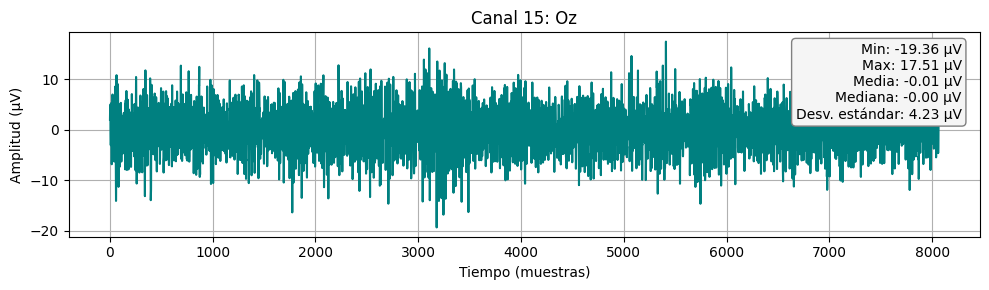

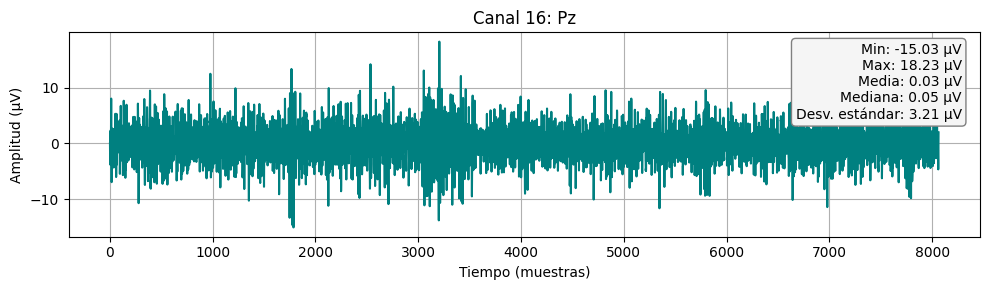

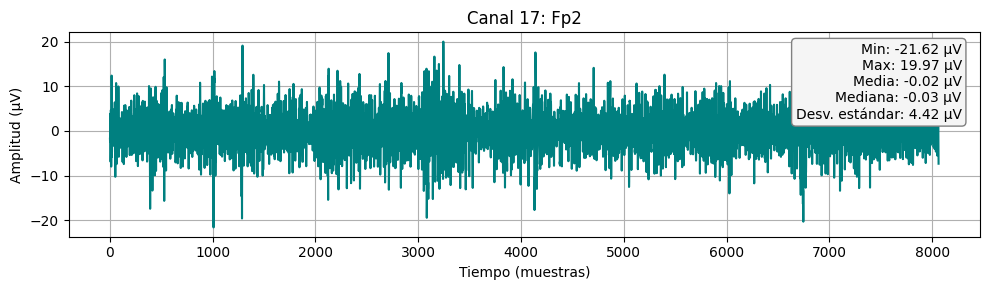

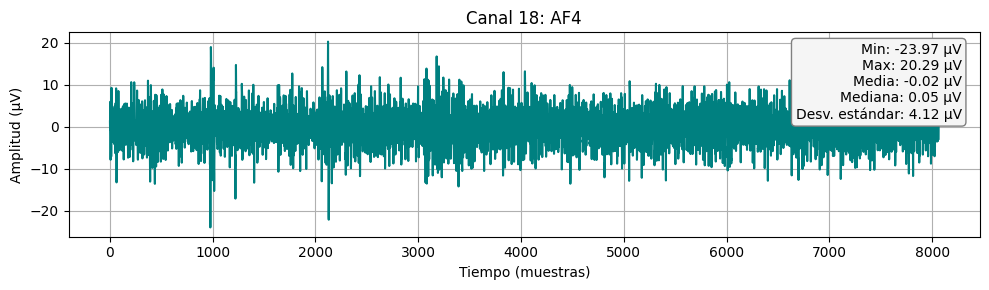

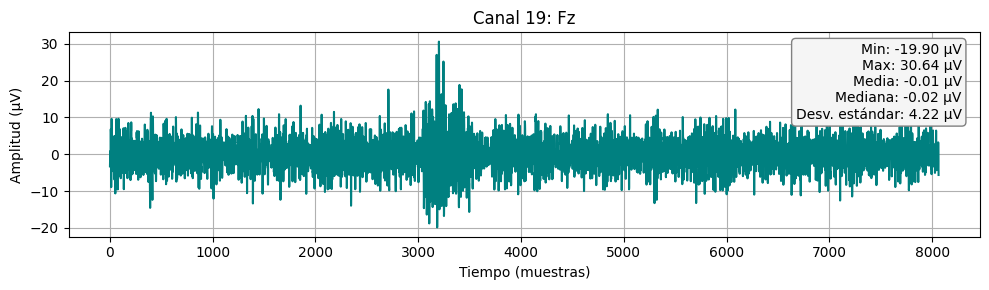

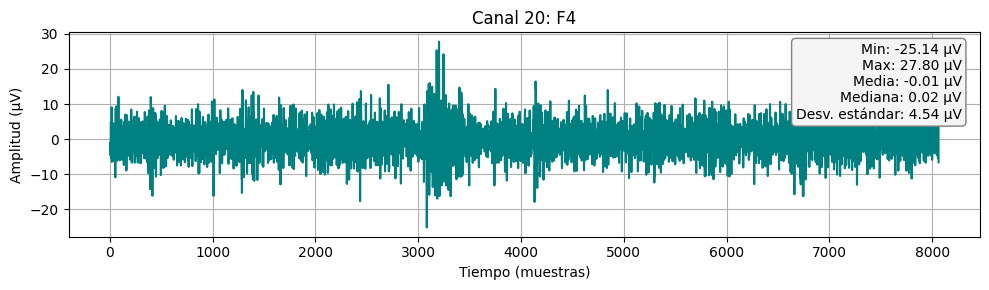

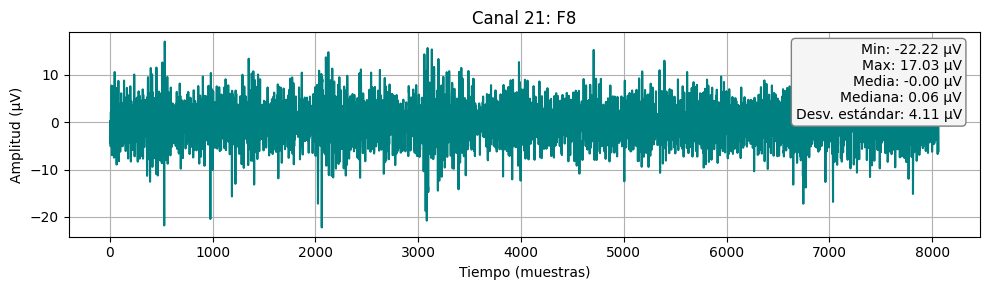

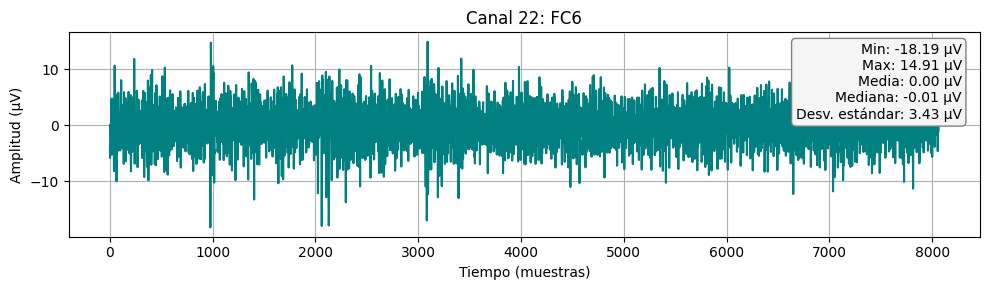

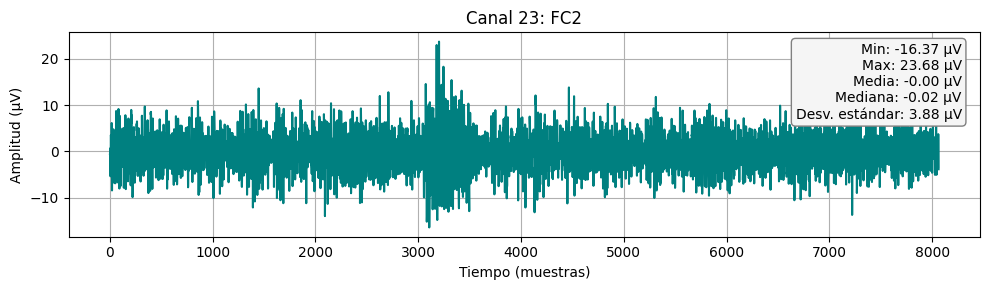

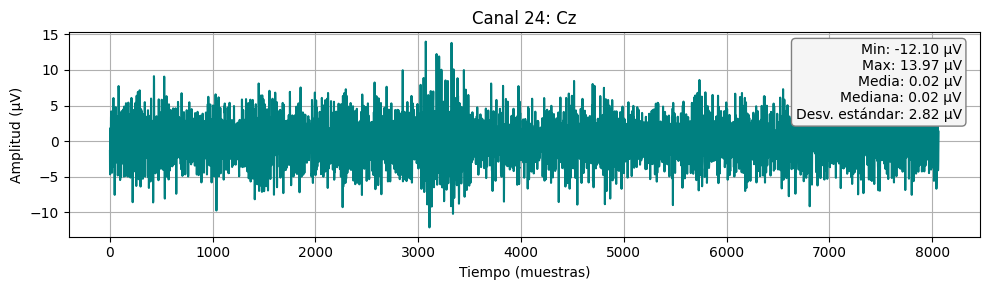

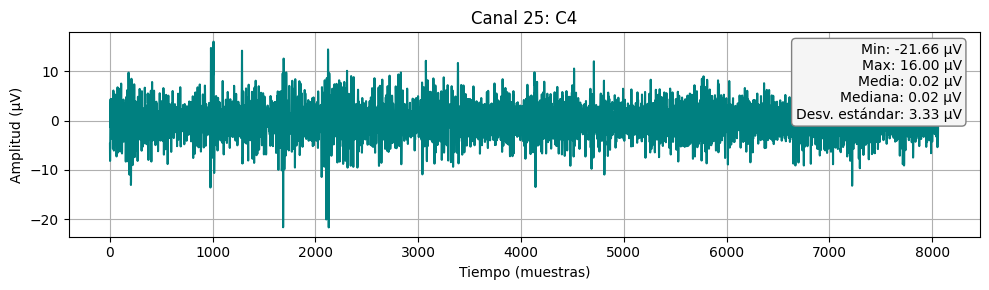

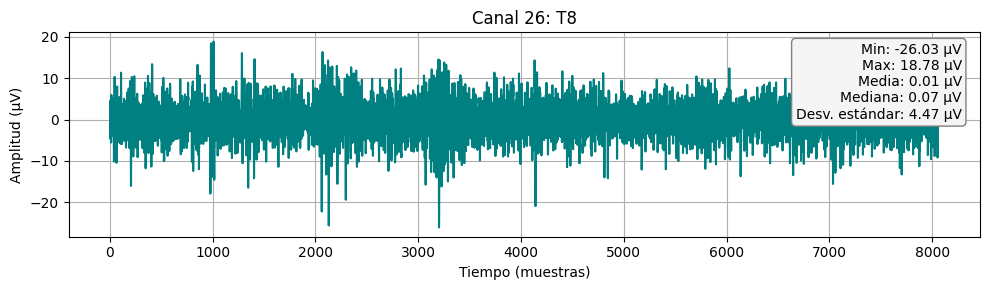

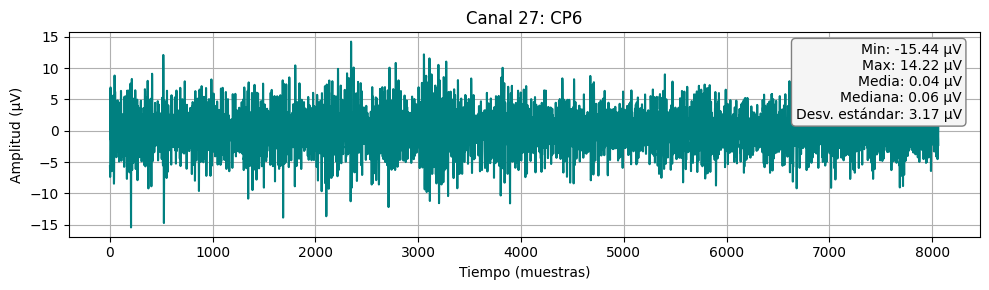

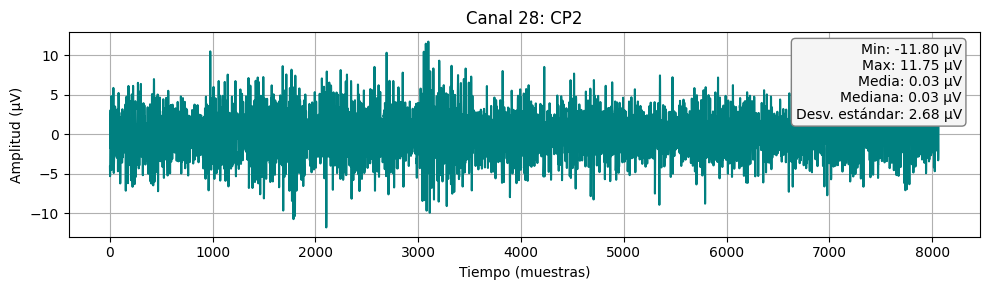

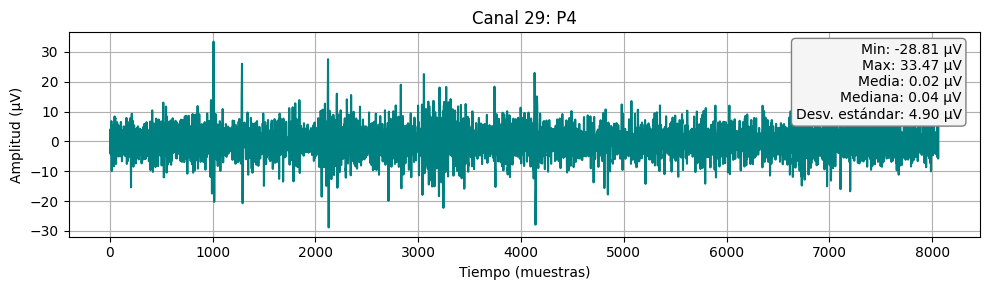

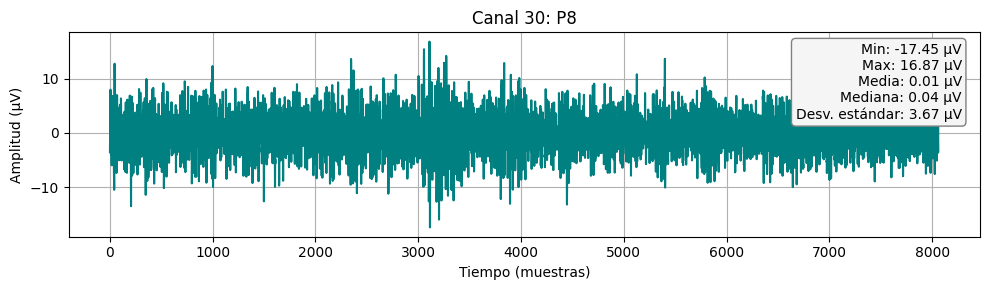

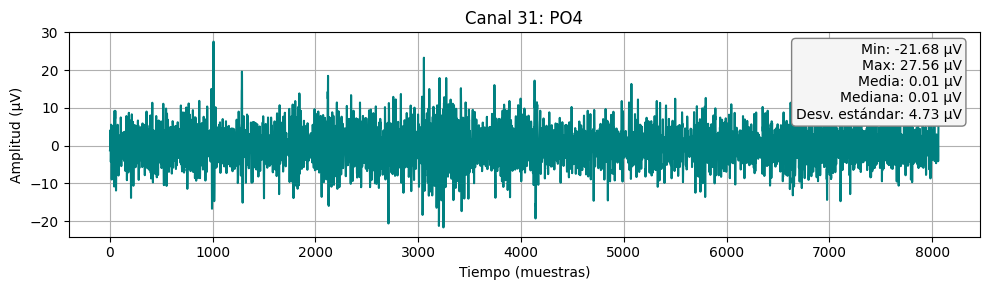

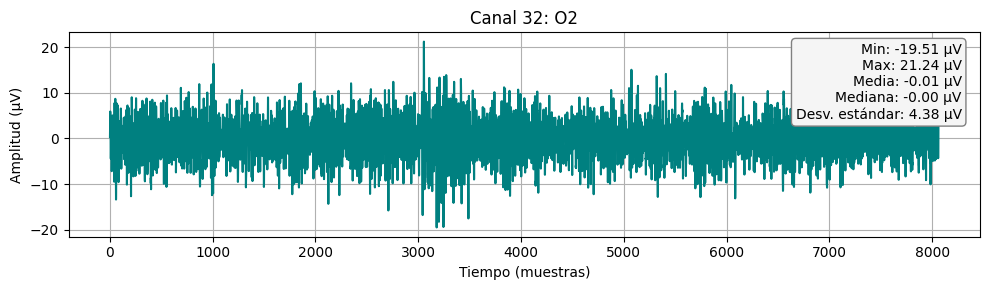

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Nombres de canales EEG según el Geneva order
channel_names = [
    'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7',
    'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz',
    'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz',
    'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2'
]

# Selecciona una muestra del dataset
sample_idx = 0
eeg_data = all_data[sample_idx, :32, :]  # (32 canales, 8064 puntos)

# Para cada canal, graficamos su señal individualmente
for i in range(32):
    señal = eeg_data[i]
    canal = channel_names[i]

    # Estadísticas
    vmin = señal.min()
    vmax = señal.max()
    mean = señal.mean()
    std = señal.std()
    median = np.median(señal)

    # Crear figura
    plt.figure(figsize=(10, 3))
    plt.plot(señal, color='teal')
    plt.title(f'Canal {i+1}: {canal}')
    plt.xlabel('Tiempo (muestras)')
    plt.ylabel('Amplitud (μV)')
    plt.grid(True)

    # Mostrar estadísticas como texto en la gráfica
    texto = (
        f"Min: {vmin:.2f} μV\n"
        f"Max: {vmax:.2f} μV\n"
        f"Media: {mean:.2f} μV\n"
        f"Mediana: {median:.2f} μV\n"
        f"Desv. estándar: {std:.2f} μV"
    )
    plt.text(0.98, 0.95, texto, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='gray'))

    plt.tight_layout()
    plt.show()


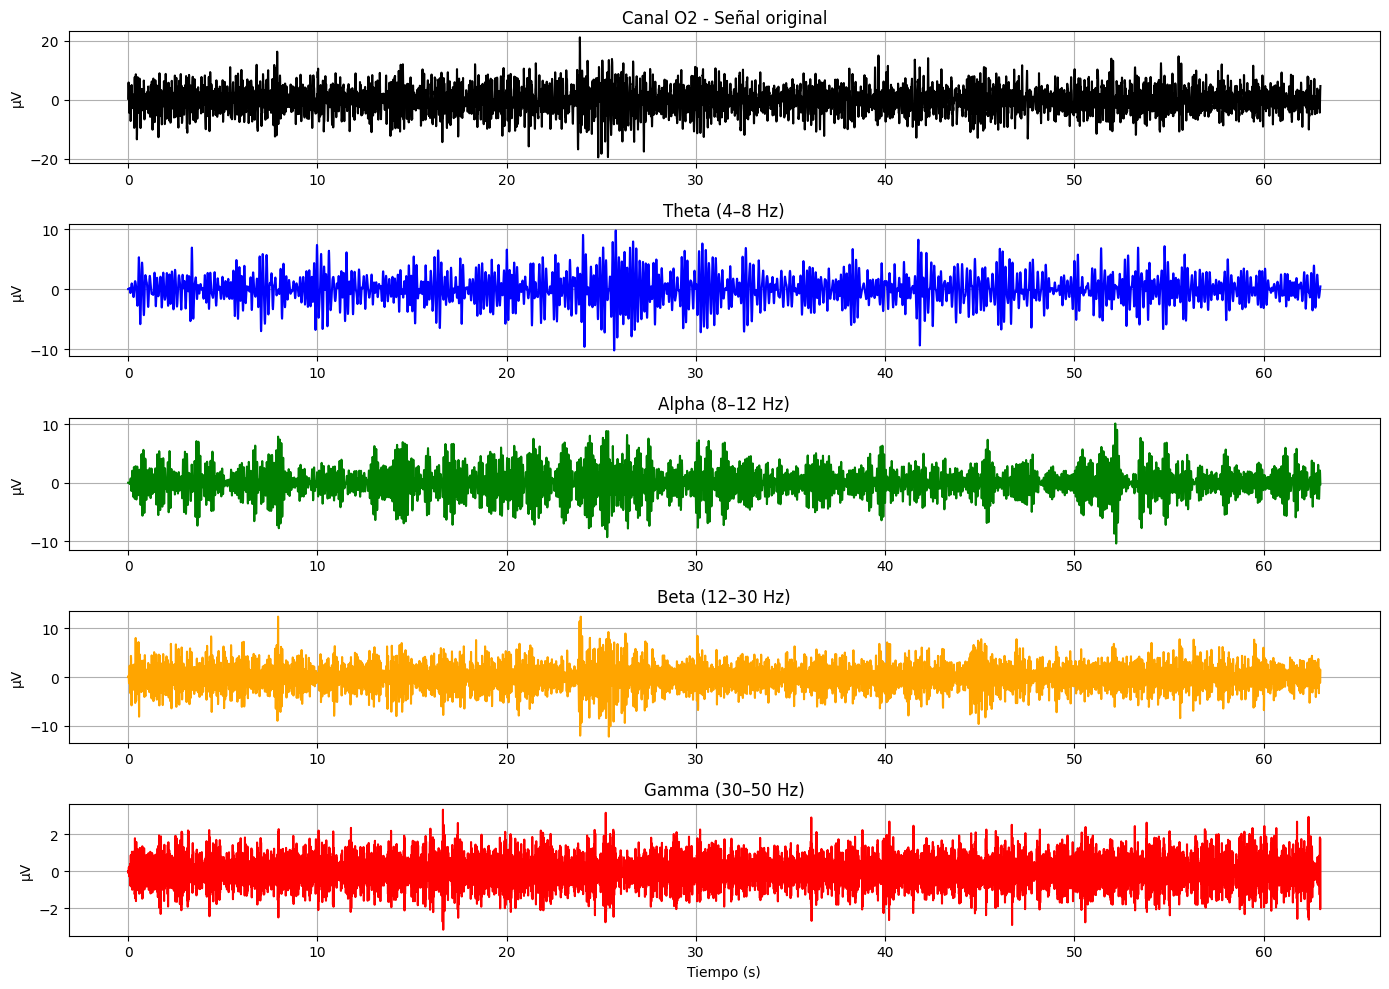

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# --------- Función para filtrar por banda ---------
def filtrar_banda(signal, low, high, fs=128, orden=4):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    b, a = butter(orden, [low/nyq, high/nyq], btype='band')
    return lfilter(b, a, signal)

# --------- Extraer la señal del canal O2 (canal 32 = índice 31) ---------
sample_idx = 0  # paciente 1, video 1
canal_idx = 31  # O2 según Geneva order

signal = all_data[sample_idx, canal_idx, :]  # shape: (8064,)
tiempo = np.arange(len(signal)) / 128  # tiempo en segundos

# --------- Aplicar filtros para bandas EEG ---------
theta = filtrar_banda(signal, 4, 8)
alpha = filtrar_banda(signal, 8, 12)
beta  = filtrar_banda(signal, 12, 30)
gamma = filtrar_banda(signal, 30, 50)

# --------- Graficar las señales ---------
plt.figure(figsize=(14, 10))

# Señal original
plt.subplot(5, 1, 1)
plt.plot(tiempo, signal, label='Original', color='black')
plt.title('Canal O2 - Señal original')
plt.ylabel('μV')
plt.grid(True)

# Theta
plt.subplot(5, 1, 2)
plt.plot(tiempo, theta, label='Theta (4–8 Hz)', color='blue')
plt.title('Theta (4–8 Hz)')
plt.ylabel('μV')
plt.grid(True)

# Alpha
plt.subplot(5, 1, 3)
plt.plot(tiempo, alpha, label='Alpha (8–12 Hz)', color='green')
plt.title('Alpha (8–12 Hz)')
plt.ylabel('μV')
plt.grid(True)

# Beta
plt.subplot(5, 1, 4)
plt.plot(tiempo, beta, label='Beta (12–30 Hz)', color='orange')
plt.title('Beta (12–30 Hz)')
plt.ylabel('μV')
plt.grid(True)

# Gamma
plt.subplot(5, 1, 5)
plt.plot(tiempo, gamma, label='Gamma (30–50 Hz)', color='red')
plt.title('Gamma (30–50 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('μV')
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
sample_idx = 0  # Cambia para ver otra muestra

# Obtener solo los primeros 32 canales (EEG) de la muestra
eeg_matrix = all_data[sample_idx, :32, :]  # shape: (32, 8064)

print(f"Matriz EEG de la muestra #{sample_idx}:")
print(eeg_matrix)
print(f"\nForma (shape): {eeg_matrix.shape}")


Matriz EEG de la muestra #0:
[[ 0.94823168  1.65333533  3.01372577 ... -2.82648937 -4.47722969
  -3.67692812]
 [ 0.12470659  1.3900827   1.83509881 ... -2.98702069 -6.28780884
  -4.47429041]
 [-2.21651099  2.29201682  2.74636923 ... -2.6370776  -7.4065101
  -6.75590441]
 ...
 [-3.55718623 -1.26030574 -3.09961982 ...  6.68885999  6.91232131
   5.66901722]
 [-1.23733173 -0.94138286  1.02804718 ...  2.6401731   6.57464869
   7.20846274]
 [ 0.37227063  2.07619495  4.46521875 ...  2.23958511  3.18256605
   4.70807159]]

Forma (shape): (32, 8064)
